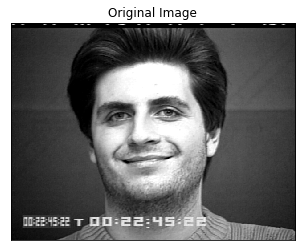

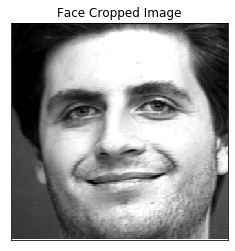

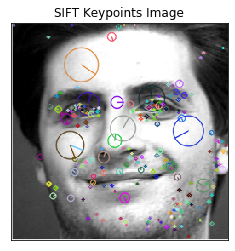

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('test.png',0)
test_image = img.copy()
plt.imshow(test_image,cmap='gray')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.title("Original Image")
plt.show()

haar_cascade_face = cv2.CascadeClassifier('data/haarcascades/haarcascade_frontalface_default.xml')
faces_rects = haar_cascade_face.detectMultiScale(test_image, scaleFactor = 1.2, minNeighbors = 5);
for (x,y,w,h) in faces_rects:
     cv2.rectangle(test_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
# plt.imshow(test_image)
# plt.show()

# Crop the image
face_cropped = test_image[y:y+h, x:x+w]
plt.imshow(face_cropped,cmap='gray')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.title("Face Cropped Image")
plt.show()

# Resize image to 256 x 256
face_cropped = cv2.resize(face_cropped, (256,256))

# SIFT
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(face_cropped, None)
img=cv2.drawKeypoints(face_cropped,kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# print(des.shape)
# print(len(kp))
plt.imshow(img)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.title("SIFT Keypoints Image")
plt.show()


In [13]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import numpy as np
import os, glob

# basedir = './SanmeshCode/k500/'
# basedir = './SanmeshCode/k500_rep/'
basedir = './SanmeshCode/k500_moretrain/'
# basedir = './SanmeshCode/k1000/'
trainingDir = ['angerHistograms', 'contemptHistograms', 'disgustHistograms', 'fearHistograms', 'happyHistograms', 'sadnessHistograms', 'surpriseHistograms']
testDir = ['angerHistogramsTest', 'contemptHistogramsTest', 'disgustHistogramsTest', 'fearHistogramsTest', 'happyHistogramsTest', 'sadnessHistogramsTest', 'surpriseHistogramsTest']
# For k1000
# trainingLabels = np.zeros((259))
# testLabels = np.zeros((67))
# For k500_moretrain (no augmentation but 90/10 split)
# trainingLabels = np.zeros((274))
# testLabels = np.zeros((52))
# For k500 (repetition augmentation)
trainingLabels = np.zeros((343))
testLabels = np.zeros((87))
trainingData = np.array([])
testData = np.array([])
dataFillCount = 0
labelCount = 0
for emotion in range(len(trainingDir)):
    subdirname = basedir + trainingDir[emotion]
    histfilenames = glob.glob(subdirname + '/' + '*.npy')

    for hist in histfilenames:
        curData = np.load(hist)
        if dataFillCount == 0:
            trainingData = curData
            dataFillCount += 1
        elif dataFillCount == 1:
            trainingData = np.stack((trainingData, curData))
            dataFillCount += 1
        else:
            trainingData = np.concatenate((trainingData, curData[np.newaxis,:]), axis=0)
        trainingLabels[labelCount] = emotion
        labelCount += 1
        
dataFillCount = 0
labelCount = 0
for emotion in range(len(testDir)):
    subdirname = basedir + testDir[emotion]
    histfilenames = glob.glob(subdirname + '/' + '*.npy')
    for hist in histfilenames:
        curData = np.load(hist)
        if dataFillCount == 0:
            testData = curData
            dataFillCount += 1
        elif dataFillCount == 1:
            testData = np.stack((testData, curData))
            dataFillCount += 1
        else:
            testData = np.concatenate((testData, curData[np.newaxis,:]), axis=0)   
        testLabels[labelCount] = emotion
        labelCount += 1
            
# print(trainingData.shape)
# print(testData.shape)
# print(trainingLabels.shape)
# print(testLabels.shape)

# Train SVM
clf = SVC(gamma='auto')
clf.fit(trainingData, trainingLabels)
prediction = clf.predict(testData)
confMat = confusion_matrix(testLabels, prediction)
print(trainingDir)
print(confMat)
accuracy = prediction - testLabels
correct = accuracy[accuracy==0]
print("Accuracy: ", correct.shape[0]/accuracy.shape[0])

['angerHistograms', 'contemptHistograms', 'disgustHistograms', 'fearHistograms', 'happyHistograms', 'sadnessHistograms', 'surpriseHistograms']
[[ 3  0  4  0  0  1  3]
 [ 1  0  2  2  1  0  5]
 [ 0  0 11  0  1  0  0]
 [ 1  0  1  0  4  0  5]
 [ 0  0  3  0 11  0  0]
 [ 3  1  2  1  1  0  3]
 [ 2  0  0  0  0  0 15]]
Accuracy:  0.45977011494252873


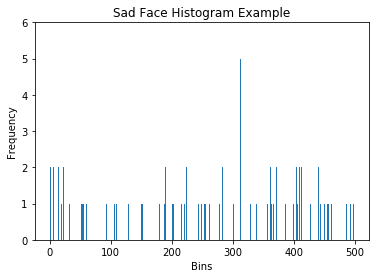

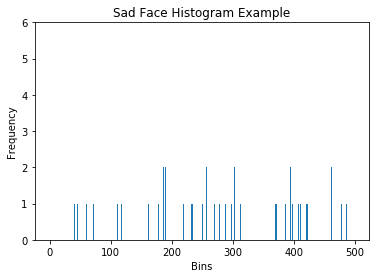

In [16]:
# To generate images for qualitative results
import numpy as np
import os, glob
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

basedir = './SanmeshCode/k500/'
# basedir = './SanmeshCode/k1000/'
trainingDir = ['happyHistograms', 'sadnessHistograms']
dataFillCount = 0
labelCount = 0
for emotion in range(len(trainingDir)):
    subdirname = basedir + trainingDir[emotion]
    histfilenames = glob.glob(subdirname + '/' + '*.npy')
    for hist in histfilenames:
        curData = np.load(hist)
        bins = np.arange(501)
        ax = plt.figure().gca()
        plt.bar(range(len(curData)), curData)
        plt.ylabel("Frequency")
        plt.xlabel("Bins")
        plt.title("Sad Face Histogram Example")
        ax.set_ylim([0,6])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()
        break